In [1]:
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, random_split
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.ndimage import binary_dilation

def extract_patches_from_edges(image_path, gt_path):
    image_gray = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    image = cv2.imread(image_path)
    gt_image = cv2.imread(gt_path)
    edges = cv2.Canny(image_gray, threshold1=50, threshold2=200)

    red_mask = (gt_image[:, :, 2] == 255) & (gt_image[:, :, 1] == 0) & (gt_image[:, :, 0] == 0)
    dilated_red_mask = binary_dilation(red_mask, iterations=3)

    patches = []
    labels = []
    h, w = image[:, :, 2].shape
    r = 3

    for y in range(r, h - r):
        for x in range(r, w - r):
            if edges[y, x] == 0:
                continue
            is_mountain_ridge = int(dilated_red_mask[y, x])
            patch = image[y - r:y + r + 1, x - r:x + r + 1]
            if patch.shape != (1+r*2, 1+r*2, 3):
                continue
            patches.append(patch)
            labels.append(is_mountain_ridge)

    return np.array(patches), np.array(labels)

In [2]:
def show_example_patches(patches, labels, label_filter=None, num_examples=10):
    if label_filter is not None:
        indices = np.where(labels == label_filter)[0]
    else:
        indices = np.arange(len(patches))
    if len(indices) == 0:
        print(f"No examples found for label {label_filter}")
        return
    plt.figure(figsize=(10, 2))
    for i, idx in enumerate(indices[:num_examples]):
        plt.subplot(1, num_examples, i + 1)
        plt.imshow(patches[idx], cmap='gray')
        plt.title(f"Label: {labels[idx]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

def load_full_dataset(image_dir, gt_dir):
    all_patches = []
    all_labels = []
    for i in tqdm(range(1, 81)):
        img_name = f"R_GImag{i:04d}.bmp"
        gt_name = f"GT_GoogleImage{i:03d}_Edge.bmp"
        image_path = os.path.join(image_dir, img_name)
        gt_path = os.path.join(gt_dir, gt_name)
        if os.path.exists(image_path) and os.path.exists(gt_path):
            patches, labels = extract_patches_from_edges(image_path, gt_path)
            all_patches.append(patches)
            all_labels.append(labels)

    all_patches = np.concatenate(all_patches, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)

    # Balance dataset
    pos_indices = np.where(all_labels == 1)[0]
    neg_indices = np.where(all_labels == 0)[0]
    n_samples = min(len(pos_indices), len(neg_indices))

    selected_pos = np.random.choice(pos_indices, n_samples, replace=False)
    selected_neg = np.random.choice(neg_indices, n_samples, replace=False)

    selected_indices = np.concatenate([selected_pos, selected_neg])
    np.random.shuffle(selected_indices)

    balanced_patches = all_patches[selected_indices]
    balanced_labels = all_labels[selected_indices]

    return balanced_patches, balanced_labels

In [3]:
train_image_dir = "web_dataset/train/images"
train_gt_dir = "web_dataset/train/ground_truth"

test_image_dir = "web_dataset/test/images"
test_gt_dir = "web_dataset/test/ground_truth"

train_patches, train_labels = load_full_dataset(train_image_dir, train_gt_dir)
print("Total patches:", len(train_patches))
print("Sample label counts:", np.bincount(train_labels))

test_patches, test_labels = load_full_dataset(test_image_dir, test_gt_dir)
print("Total patches:", len(test_patches))
print("Sample label counts:", np.bincount(test_labels))

train_patches_tensor = torch.tensor(train_patches, dtype=torch.float32).view(-1, 49*3)/255
train_conv_patches_tensor = torch.tensor(train_patches, dtype=torch.float32).permute(0, 3, 1, 2) / 255.0
train_labels_tensor = torch.tensor(train_labels, dtype=torch.float32).view(-1, 1)

test_patches_tensor = torch.tensor(test_patches, dtype=torch.float32).view(-1, 49*3)/255
test_conv_patches_tensor = torch.tensor(test_patches, dtype=torch.float32).permute(0, 3, 1, 2) / 255.0
test_labels_tensor = torch.tensor(test_labels, dtype=torch.float32).view(-1, 1)

print("Patch tensor shape:", test_patches_tensor.shape)
print("Label tensor shape:", test_labels_tensor.shape)

100%|██████████| 80/80 [00:09<00:00,  8.24it/s]


Total patches: 209324
Sample label counts: [104662 104662]


100%|██████████| 80/80 [00:02<00:00, 35.30it/s] 

Total patches: 55864
Sample label counts: [27932 27932]
Patch tensor shape: torch.Size([55864, 147])
Label tensor shape: torch.Size([55864, 1])


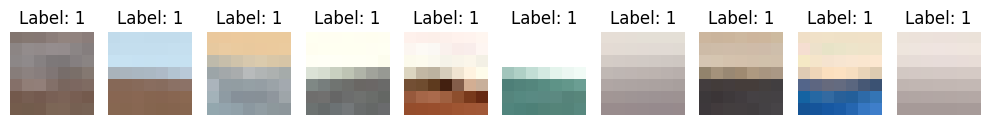

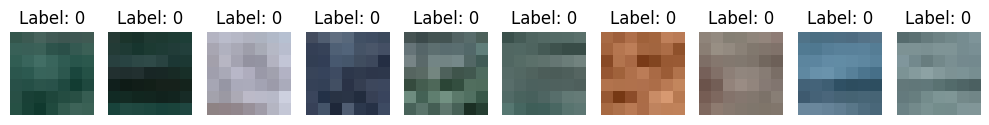

In [4]:
show_example_patches(patches, labels, label_filter=1)
show_example_patches(patches, labels, label_filter=0)

In [5]:
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

class RidgeClassifier(nn.Module):
    def __init__(self):
        super(RidgeClassifier, self).__init__()
        self.fc1 = nn.Linear(147, 16)
        # self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 1) 

    def forward(self, x):
        x = F.relu(self.fc1(x))
        # x = F.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x

class ConvRidgeClassifier(nn.Module):
    def __init__(self):
        super(ConvRidgeClassifier, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.pool = nn.AdaptiveAvgPool2d((1, 1))  # Reduce to 1x1
        self.fc = nn.Linear(32, 1)  # Final classifier

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)  # Shape: [batch_size, 32, 1, 1]
        x = x.view(x.size(0), -1)  # Flatten to [batch_size, 32]
        x = torch.sigmoid(self.fc(x))
        return x

In [6]:
from torch.utils.data import random_split

# Train-test split (80-20)
test_dataset = TensorDataset(test_patches_tensor, test_labels_tensor)
train_dataset = TensorDataset(train_patches_tensor, train_labels_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

model = RidgeClassifier()
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)
criterion = nn.BCELoss()

for epoch in range(25):
    model.train()
    total_train_loss = 0.0
    total_train_samples = 0
    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

        batch_size = batch_y.size(0)
        total_train_loss += loss.item() * batch_size  # Weighted by batch size
        total_train_samples += batch_size

    avg_train_loss = total_train_loss / total_train_samples

    model.eval()
    total_test_loss = 0.0
    total_test_samples = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)

            batch_size = batch_y.size(0)
            total_test_loss += loss.item() * batch_size  # Weighted by batch size
            total_test_samples += batch_size

            predicted = (outputs > 0.5).float()
            correct += (predicted == batch_y).sum().item()
            total += batch_size

    avg_test_loss = total_test_loss / total_test_samples

    print(f"Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}, Test Accuracy: {100 * correct / total:.2f}%")

show_example_patches(patches, labels, label_filter=1)

Epoch 1, Train Loss: 0.1120, Test Loss: 0.2186, Test Accuracy: 91.58%
Epoch 2, Train Loss: 0.0908, Test Loss: 0.2609, Test Accuracy: 89.68%
Epoch 3, Train Loss: 0.0871, Test Loss: 0.2228, Test Accuracy: 91.73%
Epoch 4, Train Loss: 0.0849, Test Loss: 0.2210, Test Accuracy: 91.67%
Epoch 5, Train Loss: 0.0824, Test Loss: 0.1911, Test Accuracy: 92.47%
Epoch 6, Train Loss: 0.0809, Test Loss: 0.2262, Test Accuracy: 91.44%
Epoch 7, Train Loss: 0.0789, Test Loss: 0.2072, Test Accuracy: 92.01%
Epoch 8, Train Loss: 0.0767, Test Loss: 0.1974, Test Accuracy: 92.45%
Epoch 9, Train Loss: 0.0758, Test Loss: 0.1994, Test Accuracy: 91.98%
Epoch 10, Train Loss: 0.0741, Test Loss: 0.1631, Test Accuracy: 93.59%
Epoch 11, Train Loss: 0.0737, Test Loss: 0.1979, Test Accuracy: 92.42%
Epoch 12, Train Loss: 0.0720, Test Loss: 0.1792, Test Accuracy: 93.14%
Epoch 13, Train Loss: 0.0716, Test Loss: 0.1836, Test Accuracy: 93.00%
Epoch 14, Train Loss: 0.0708, Test Loss: 0.1670, Test Accuracy: 93.56%
Epoch 15, Train

NameError: name 'patches' is not defined

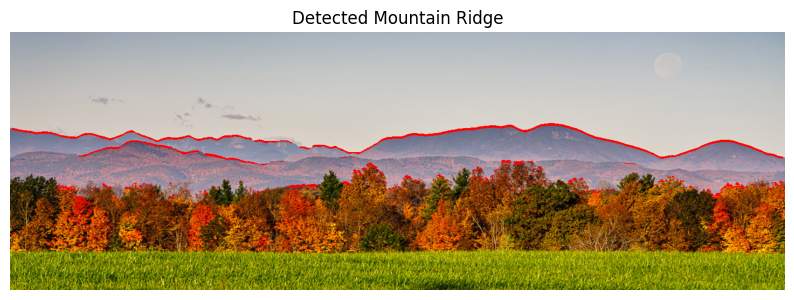

In [7]:
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt

# Load image
img_path = "test_images/midd.jpg"
image = cv2.imread(img_path)

# Get original dimensions
original_height, original_width = image.shape[:2]

# Desired width
new_width = 1388

# Calculate new height to maintain aspect ratio
aspect_ratio = original_height / original_width
new_height = int(new_width * aspect_ratio)

# Resize the image
image = cv2.resize(image, (new_width, new_height))

image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
edges = cv2.Canny(image_gray, 50, 200)

# Set up
r = 3
h, w = image[:, :, 2].shape
output_img = cv2.cvtColor(image, cv2.IMREAD_COLOR)  # to draw in color

prob_map = np.zeros_like(image_gray, dtype=np.float32)

# Loop over edge pixels
for y in range(r, h - r):
    for x in range(r, w - r):
        # if edges[y, x] == 0:
        #     continue
        patch = image[y - r:y + r + 1, x - r:x + r + 1]
        # if patch.shape != (7, 7, 3):
        #     continue
        patch_tensor = torch.tensor(patch, dtype=torch.float32).view(1, 147) / 255.0
        # patch_tensor = torch.tensor(patch, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0) / 255.0

        with torch.no_grad():
            prob = model(patch_tensor).item()
        if prob > 0.95:
            output_img[y, x] = [0, 0, 255]  # red (BGR)
        prob_map[y, x] = prob

# Show image
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(output_img, cv2.COLOR_BGR2RGB))
plt.title("Detected Mountain Ridge")
plt.axis("off")
plt.show()

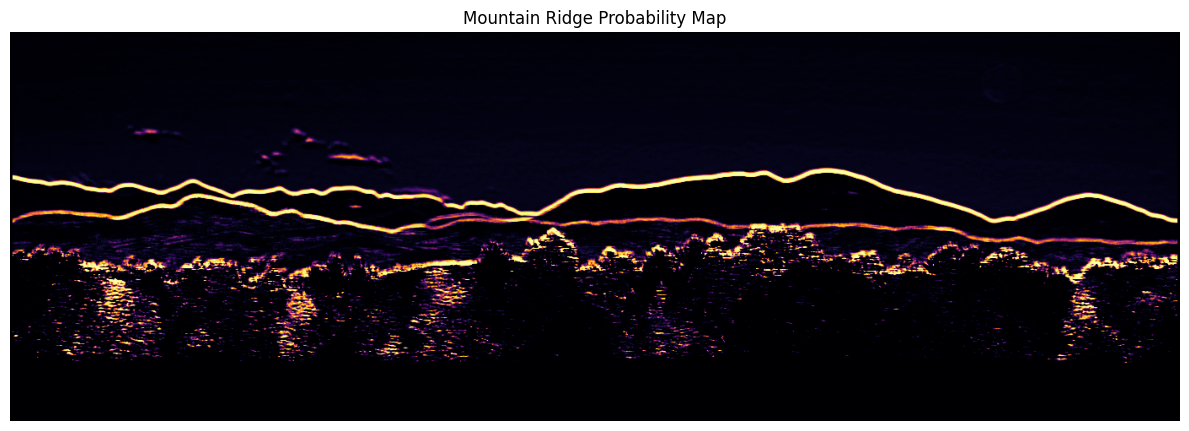

In [8]:
plt.figure(figsize=(12, 5))

# plt.subplot(1, 2, 2)
plt.title("Mountain Ridge Probability Map")
plt.imshow(prob_map, cmap='inferno', vmin=0, vmax=1)
plt.axis('off')

# plt.subplot(1, 2, 1)
# plt.title("Canny Edges")
# plt.imshow(edges)
# plt.axis('off')

plt.tight_layout()
plt.show()

In [9]:
import numpy as np

def find_ridge(prob_map, delta=5, epsilon=1e-6):
    H, W = prob_map.shape
    cost = np.full((H, W), np.inf)
    backtrack = np.full((H, W), -1, dtype=int)

    # Convert prob_map to cost map using negative log
    log_cost = -np.log(prob_map + epsilon)

    # Initialize first column
    cost[:, 0] = log_cost[:, 0]

    for x in range(1, W):
        for y in range(H):
            y_min = max(y - delta, 0)
            y_max = min(y + delta + 1, H)
            for yy in range(y_min, y_max):
                transition_cost = abs(y - yy)
                total_cost = cost[yy, x-1] + transition_cost + log_cost[y, x]
                if total_cost < cost[y, x]:
                    cost[y, x] = total_cost
                    backtrack[y, x] = yy

    # Backtrace the path
    ridge = np.zeros(W, dtype=int)
    ridge[-1] = np.argmin(cost[:, -1])
    for x in range(W - 2, -1, -1):
        ridge[x] = backtrack[ridge[x + 1], x + 1]

    return ridge

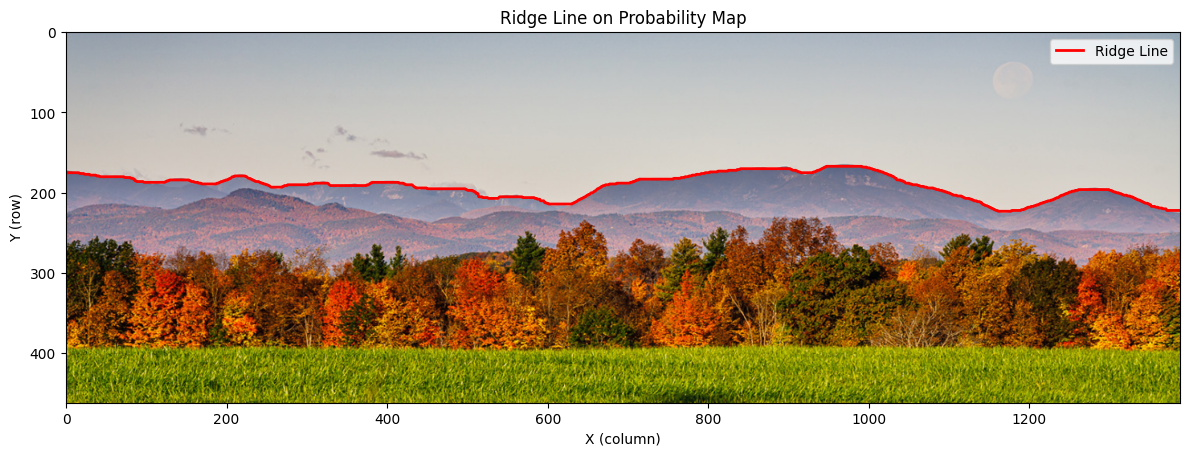

In [10]:
ridge = find_ridge(prob_map)

def plot_ridge(image, ridge):
    plt.figure(figsize=(12, 6))
    plt.imshow(image)
    plt.plot(range(len(ridge)), ridge, color='red', linewidth=2, label='Ridge Line')
    plt.title('Ridge Line on Probability Map')
    plt.xlabel('X (column)')
    plt.ylabel('Y (row)')
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_ridge(cv2.cvtColor(image, cv2.COLOR_BGR2RGB), ridge)

In [11]:
def get_patch(image, x, y, r):
    h, w, _ = image.shape
    if y - r < 0 or y + r + 1 > h or x - r < 0 or x + r + 1 > w:
        return None
    return image[y - r:y + r + 1, x - r:x + r + 1]

def find_ridge_new(image, model):
    r = 3
    h, w = image[:, :, 2].shape

    ridge = []
    first_column = [0 for _ in range(r)]

    for y in range(r, h - r):
        patch = get_patch(image, r, y, r)
        if patch is None: continue
        patch_tensor = torch.tensor(patch, dtype=torch.float32).view(1, 147) / 255.0
        with torch.no_grad():
                prob = model(patch_tensor).item()
        first_column.append(prob)

    search_r = 3
    first_column_sorted = sorted(first_column, reverse=True)
    pred_mtn_height = first_column.index(first_column_sorted[0])
    for i in range(r):
        ridge.append(pred_mtn_height)
    
    search_space = []
    ridge_probs = [1, 1, 1]
    x = r+1
    t = 0

    while x < (w - r):
        for y in range(pred_mtn_height-search_r, pred_mtn_height+search_r+1):
            patch = get_patch(image, x, y, r)
            if patch is None: continue
            patch_tensor = torch.tensor(patch, dtype=torch.float32).view(1, 147) / 255.0
            with torch.no_grad():
                prob = model(patch_tensor).item()
            search_space.append(prob)
        
        pred_mtn_height -= r - search_space.index(max(search_space))
        ridge.append(pred_mtn_height)
        ridge_probs.append(max(search_space))

        # Restart search if probability of found line is too low
        if sum(ridge_probs)/len(ridge_probs) < 0.8:
            if t >= 10:
                search_r += 1
                t = 0

            t += 1
            ridge = []
            
            pred_mtn_height = first_column.index(first_column_sorted[t])
            for i in range(r):
                ridge.append(pred_mtn_height)
            
            x = r+1
            search_space = []
            ridge_probs = [1, 1, 1, first_column_sorted[t]]
            
            continue
        
        x += 1
        search_space = []
    
    return ridge

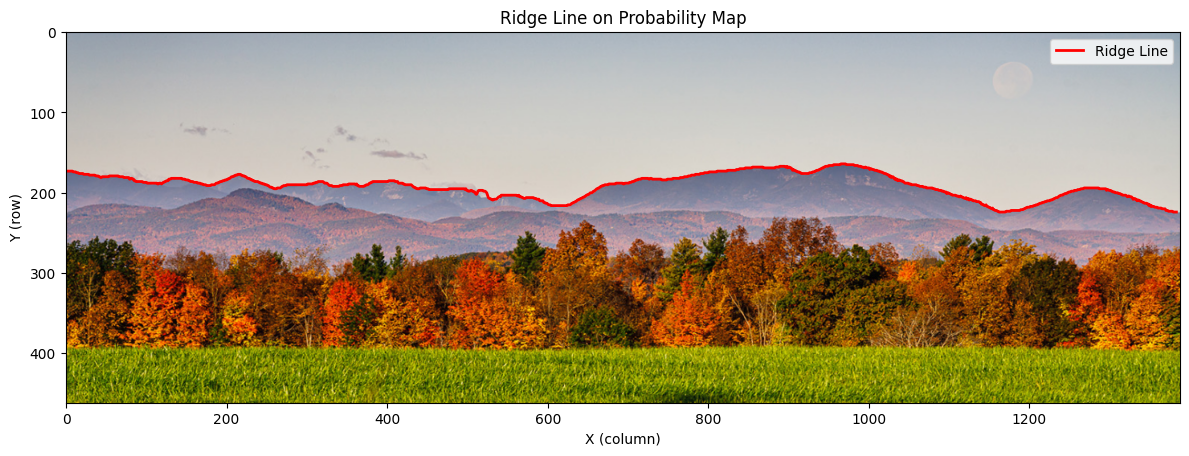

In [12]:
# Load image
img_path = "test_images/midd.jpg"
image = cv2.imread(img_path)

# Get original dimensions
original_height, original_width = image.shape[:2]

# Desired width
new_width = 1388

# Calculate new height to maintain aspect ratio
aspect_ratio = original_height / original_width
new_height = int(new_width * aspect_ratio)

# Resize the image
image = cv2.resize(image, (new_width, new_height))

image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
edges = cv2.Canny(image_gray, 50, 200)

ridge = find_ridge_new(image, model)
plot_ridge(cv2.cvtColor(image, cv2.COLOR_BGR2RGB), ridge)